# ELO Scores for Trainers and Jockeys

This R notebook looks at a year of horse racing records from the Monmouth Park racetrack in Ocean Township, NJ. 

Unfortunately, data for this sport is often locked behind substantial paywalls and is very hard to get in a bulk fashion (i.e. not one race at a time). Thus, I limited the scope of the project to one year of races at my home track. The methodology could be extended, of course, to give a better sense of the competitive landscape in horse racing.

In [1]:
library(data.table)
library(gbm)
library(caret)

Warning message:
"package 'gbm' was built under R version 3.3.3"Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: ggplot2

Attaching package: 'caret'

The following object is masked from 'package:survival':

    cluster



In [2]:
mmpark.data <- data.table(read.csv('../Desktop/MMPark - Sheet1.csv'))

## Jockey Stats
Let's start with the more visible of these two, the jockey. It turns out, theres a pretty fascinating back and forth negotiation going on to decide which jockeys ride which horses. You can find details here! http://blog.littleredfeather.com/how-do-thoroughbred-partnerships-pick-a-jockey-for-their-racehorses

The gist, though, is jockeys get paid when they win. Naturally, they gravitate to horses that tend to perform well, and can even jump from horse to horse if they get a better offer. We should expect, then, that certain jockeys will be more likely to win than others.

Importantly, this means it will be hard to disentangle the effect of the jockey from the effect of the horse. If better jockeys get better horses, you can't really tell which is adding the value! This could be resolved to a degree by ranking horses as well - since we only have one track of data, and horses tend to travel, that is out of scope here.

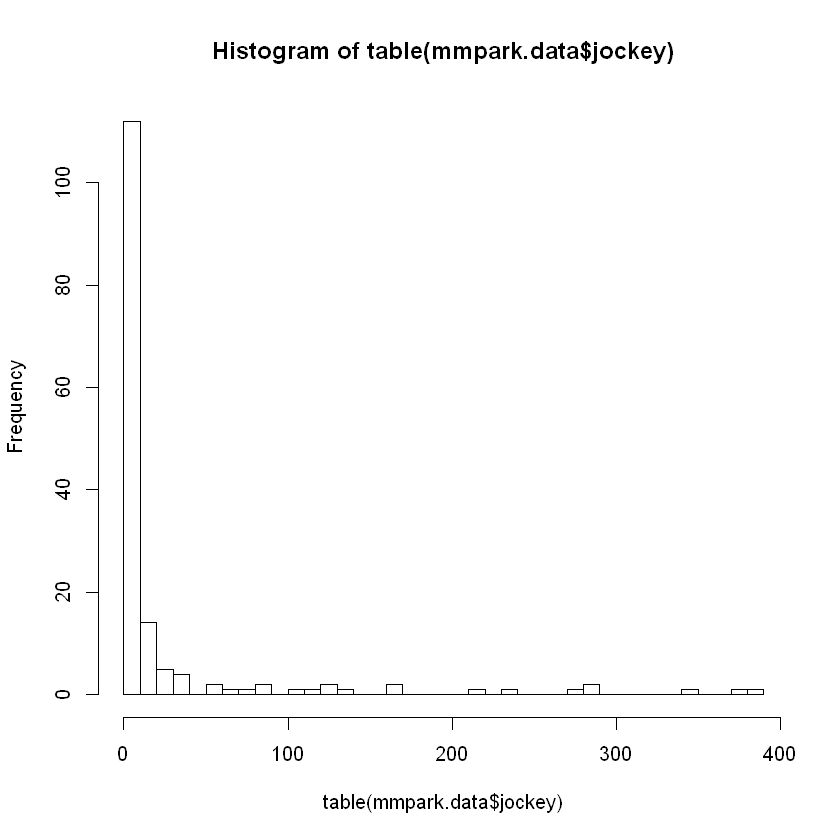

In [3]:
hist(table(mmpark.data$jockey), breaks = 30)

We see that, overall, there are a few jockeys who race 100s of times each, but many who race relatively few times, even as rarely as once at this track. It's possible these jockeys travel with the horses, but they may also be new and beginning their career. 

## Calculating Jockey ELO scores

A common metric for this type of comparison is an ELO score. As a high-level summary, we'll assign a starting number of points, in this case 1500 per jockey. Each time a jockey wins, they'll take some points from the jockeys they beat. The amount they'll take scales with the mismatch - if we already believe Jockey A is far better than Jockey B, we don't learn much if Jockey A wins. We learn a ton, though, if Jockey B wins.

A small wrinkle, though - ordinarily this metric applies only to things with one winner and one loser (think chess, football...). In horse racing, you will have one winner, but you may have 12 losers! Thus, we'll need to be a bit clever here:
* First, we'll make each race into a set of head to head competitions. That is, did horse 1 beat horse 2? Did horse 1 beat horse 3? Did horse 2 beat horse 3?...
* To avoid giving too much credit to any one race, we'll scale the normal calculation by the number of horses in the race. 

This has the advantage of maximizing our learnings. We not only learn about the horse that won, but about all the others as well!

In [4]:
mmpark.data <- mmpark.data[, unique_race_id := paste(track, date, race, sep = '_')]
jockey.data <- mmpark.data[, list(unique_race_id, jockey, finish.position)]

From this snippet, we see a single race, from 5/14/2016. Notice that Lopez Pascacio won, and Kay Winston R was in last place. We'll use these kinds of rankings to calculate the ELO scores

In [5]:
jockey.data <- jockey.data[order(unique_race_id, finish.position)]
jockey.data <- jockey.data[, num_horses := .N, unique_race_id]
head(jockey.data, 7)

unique_race_id,jockey,finish.position,num_horses
MTH_20160514_1,LOPEZ PASCACIO,1,7
MTH_20160514_1,GUDIEL VICENTE,2,7
MTH_20160514_1,ALVARADO R JR,3,7
MTH_20160514_1,GONZALES JONATHAN J,4,7
MTH_20160514_1,ESQUIVEL EMMANUEL,5,7
MTH_20160514_1,FRAGOSO P,6,7
MTH_20160514_1,KAY WINSTON R,7,7


We'll initialize every jockey at 1500; we'll also start keep track of the number of races, so we can follow the formula here: https://ratings.fide.com/calculator_rtd.phtml

In [6]:
getKMultiplier <- function(num_races, score) {
    
    new.multipliers <- rep(20, length(num_races))
    
    new.multipliers[score > 2400] <- 10
   
    new.multipliers[num_races < 30] <- 40

    return(new.multipliers)
}

jockey.elo.scores <- data.table('jockey' = unique(jockey.data$jockey)
                                , 'score' = 1500
                                , 'num_races' = 0
                                , 'k_multiplier' = getKMultiplier(0, 1500))
head(jockey.elo.scores)

jockey,score,num_races,k_multiplier
LOPEZ PASCACIO,1500,0,40
GUDIEL VICENTE,1500,0,40
ALVARADO R JR,1500,0,40
GONZALES JONATHAN J,1500,0,40
ESQUIVEL EMMANUEL,1500,0,40
FRAGOSO P,1500,0,40


In [7]:
calculateELOUpdate <- function(elo.table, winner.name, loser.name, num.competitors) {
    elo.table <- copy(elo.table)
    rating_winner <- elo.table[jockey == winner.name, score]
    rating_loser <- elo.table[jockey == loser.name, score]
    
    qa <- ratingToQScore(rating_winner)
    qb <- ratingToQScore(rating_loser)
    
    exp_a <- qa / (qa + qb)
    exp_b <- qb / (qa + qb)
    
    elo.table[jockey == winner.name
              , c('num_races', 'score') := 
              list(num_races + 1 / num.competitors
                   , score + (k_multiplier / num.competitors * (1 - exp_a)))]
    
    elo.table[jockey == loser.name
              , c('num_races', 'score') := 
              list(num_races + 1 / num.competitors
                   , score + (k_multiplier / num.competitors * (0 - exp_b)))]                      
    
    elo.table[jockey %in% c(winner.name, loser.name)
             , 'k_multiplier' := getKMultiplier(num_races, score)]
    
    return(elo.table)
   
}

ratingToQScore <- function(rating) {
    return (10 ^ (rating / 400))
}

processRaceResult <- function(elo.table, race.result) {
    jockey.order <- race.result[order(finish.position)]$jockey
    
    for (winner in 1:(length(jockey.order) - 1)) {
        for (loser in (winner + 1):length(jockey.order)) {
            elo.table <- calculateELOUpdate(elo.table
                                            , winner.name = jockey.order[winner]
                                            , loser.name = jockey.order[loser]
                                            , num.competitors = length(jockey.order) - 1)
        }
    }
    
    return(elo.table)
}



In [8]:
calculateELOUpdate(jockey.elo.scores
                   , winner.name = 'LOPEZ PASCACIO'
                   , loser.name = 'GUDIEL VICENTE'
                   , num.competitors = 1)

jockey,score,num_races,k_multiplier
LOPEZ PASCACIO,1520,1,40
GUDIEL VICENTE,1480,1,40
ALVARADO R JR,1500,0,40
GONZALES JONATHAN J,1500,0,40
ESQUIVEL EMMANUEL,1500,0,40
FRAGOSO P,1500,0,40
KAY WINSTON R,1500,0,40
CENTENO D E,1500,0,40
RODRIGUEZ E D,1500,0,40
GRYDER A T,1500,0,40


Note Lopez Pascacio adds about 20 points to his score for winning, while Kay Winston R loses about 20 points. Gonzales Jonathan finished right in the middle, so his score stays at 1500

In [9]:
processRaceResult(elo.table = jockey.elo.scores, race.result = jockey.data[unique_race_id == 'MTH_20160514_1', ])

jockey,score,num_races,k_multiplier
LOPEZ PASCACIO,1519.527,1,40
GUDIEL VICENTE,1513.021,1,40
ALVARADO R JR,1506.514,1,40
GONZALES JONATHAN J,1500.004,1,40
ESQUIVEL EMMANUEL,1493.493,1,40
FRAGOSO P,1486.979,1,40
KAY WINSTON R,1480.463,1,40
CENTENO D E,1500.000,0,40
RODRIGUEZ E D,1500.000,0,40
GRYDER A T,1500.000,0,40


In [10]:
for (race in sort(unique(jockey.data[['unique_race_id']]))) {
    jockey.elo.scores <- processRaceResult(elo.table = jockey.elo.scores
                                           , race.result = jockey.data[unique_race_id == race])
}
     
print(jockey.elo.scores)

                  jockey    score num_races k_multiplier
  1:      LOPEZ PASCACIO 1622.295       349           40
  2:      GUDIEL VICENTE 1482.406        11           40
  3:       ALVARADO R JR 1481.550        52           40
  4: GONZALES JONATHAN J 1631.961       233           40
  5:   ESQUIVEL EMMANUEL 1549.741        22           40
 ---                                                    
152:     SALGADO ANTHONY 1505.515         2           40
153:         MILLER JENN 1493.318         1           40
154:      HADDOCK DEXTER 1492.359         1           40
155:    MURRILL MITCHELL 1510.249         2           40
156:   BETANCOURT JOSE R 1481.059         1           40


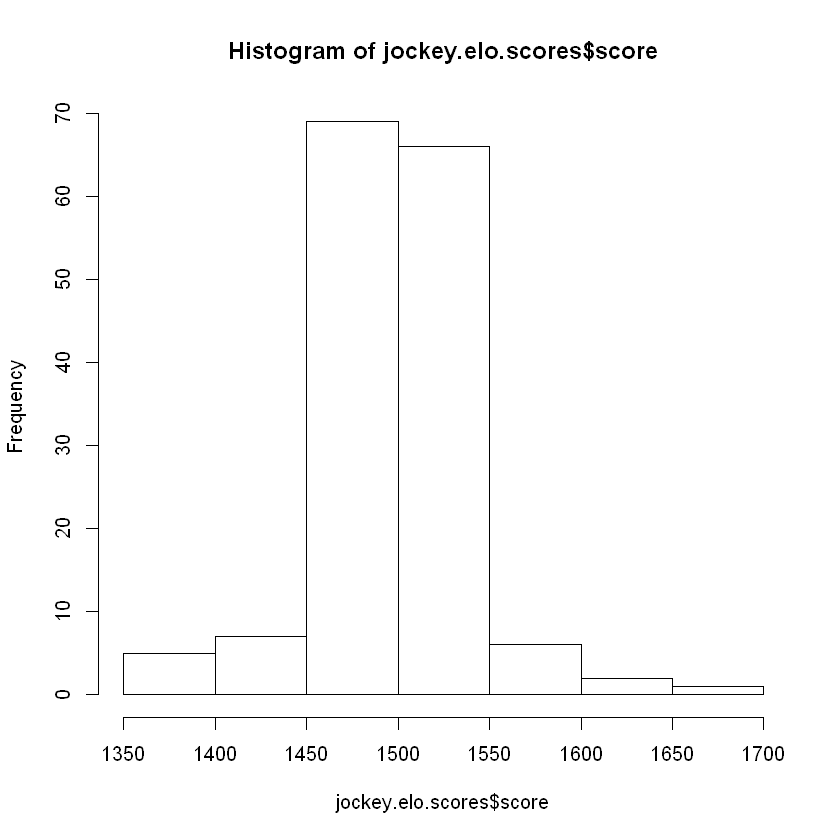

In [11]:
hist(jockey.elo.scores$score)